In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from analysis_utils import *

os.chdir('../')
os.getcwd()

'/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment'

# Analysis from pRF+AttnStim

Load data into Pandas dataframe. To be implemented: run some tests to ensure data quality

- does run exist? 
- does run contain responses?
- does run log color_balance and fix_intensity values correctly?

In [2]:
f_names = glob.glob("logs/*/*.tsv")
all_logs = load_data(f_names)
all_logs[(all_logs.run == '11')].head()

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,color,run
498,0,0.378054,stim,1,NaN,35.0,0.5,0.0,3.719669,0.374999,0.753054,4.094669,largeAF,gray,11
499,0,1.128051,stim,3,NaN,34.0,0.5,0.0,4.469666,0.375001,1.503052,4.844667,largeAF,gray,11
500,1,1.878051,stim,1,NaN,35.0,0.5,0.0,5.219666,0.374993,2.253044,5.594659,largeAF,gray,11
501,1,2.628045,stim,3,NaN,36.0,0.8,0.0,5.969660,0.382127,3.010172,6.351787,largeAF,gray,11
502,2,3.226905,response,0,space,0.0,0.8,0.0,6.568521,0.000000,3.226905,6.568521,largeAF,gray,11


Calculate correct and incorrect responses. Use this to get hits (true positives), misses (false negatives), false alarms (false positives) and correct rejections (true negatives). Once we have these values we can calculate d'

In [51]:
psyc, large_cor, small_cor = analyse_logs(all_logs)
psyc

,run,task,hits,misses,fas,correjs,dprime,accuracy
0,7,color_balance,60,28,1,332,3.220242,0.931116
1,8,fix_intensity,35,53,2,307,2.226045,0.861461
2,9,color_balance,33,39,2,337,2.413454,0.900243
3,10,fix_intensity,47,25,3,351,2.780640,0.934272
4,11,color_balance,36,36,0,340,2.973820,0.912621


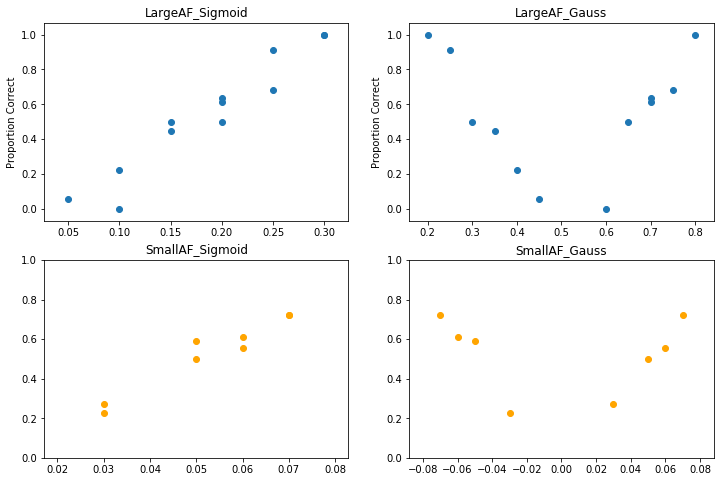

In [67]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,8))

ax1.set_title('LargeAF_Sigmoid')
ax1.scatter([abs(i[0]-0.5) for i in large_cor], [i[1] for i in large_cor])
ax1.set_ylabel('Proportion Correct')

ax2.set_title('LargeAF_Gauss')
ax2.scatter([i[0] for i in large_cor], [i[1] for i in large_cor])
ax2.set_ylabel('Proportion Correct')

ax3.set_title('SmallAF_Sigmoid')
ax3.set_ylim(0,1)
ax3.scatter([abs(i[0]-0) for i in small_cor], [i[1] for i in small_cor], color='orange')

ax4.set_title('SmallAF_Gauss')
ax4.set_ylim(0,1)
ax4.scatter([i[0] for i in small_cor], [i[1] for i in small_cor], color='orange')

# Modeling psychometric curve

In [68]:
def model_pr():
    '''
    return array of probabilities corresponding to GAUSSIAN cdf
    stimuli is range of color_balances / fix intensities
    loc
    sd / scale
    '''
    
    stim_x = np.arange(0,1,0.05)
    mu = 0.5
    sd = 0.1
    
    model_pr = norm.cdf(stim_x, mu,sd)
    
    return stim_x, model_pr

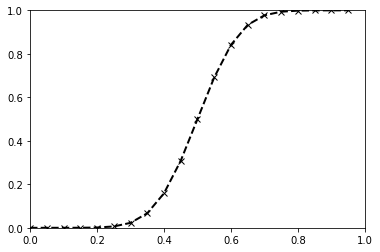

In [69]:
x,pr = model_pr()
plt.plot(x, pr, color='k', marker='x', lw=2, ls='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()